In [1]:
import ibmos2spark

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

metadata = {
    'endpoint': 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-b4645dff-b482-4bf0-80c5-7d3c715249ab',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'Km7tNFaU82dDAZrA2ocu9WJwkstQJS45prU7EIHCYpt9'
}

configuration_name = 'os_feaf38c82f9d4cc1a922e2c013c9fd9b_configs'
cos = ibmos2spark.CloudObjectStorage(sc, metadata, configuration_name, 'bluemix_cos')
url = cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ra4ikqizj2oys8')

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: https://spark.apache.org/docs/3.3.1/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.json.html#pyspark.sql.DataFrameReader.json

event_data = spark.read.json(url)
event_data.show(10)


+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford| Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body| Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000

In [2]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, col, concat, desc, explode, sum,\
    lit, min, max, split, udf, from_unixtime, when, expr, round, count, \
    current_timestamp, to_date, countDistinct, year, month, dayofmonth, \
    current_date, datediff, isnan
from pyspark.sql.types import IntegerType, DoubleType, LongType, DateType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
    RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, \
    StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.pipeline import PipelineModel

import datetime

import re

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Clean Dataset
In this notebook, the medium sized-dataset file is `medium-sparkify-event-data.json` was loaded. Clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
event_data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [4]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Number of events
event_data.count()

543705

In [7]:
# Unique UserIds
event_data.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



There are no missing values in the userID or session columns. However, there are userID values that are empty strings. These cases are perhaps unresgistered users or users about to log in.

In [8]:
# Events by gender
event_data.groupBy("gender").count().dropDuplicates().show()

+------+------+
|gender| count|
+------+------+
|     F|225393|
|  null| 15700|
|     M|302612|
+------+------+



There are null values for gender, probably regarding the empty string UserIds. We need to drop thes cases.

In [5]:
# Valid userId and sessionId
event_data_valid = event_data.dropna(how = "any", subset = ["userId", "sessionId", 'gender', 'location'])

In [6]:
# Number of valid userId and sessionId
event_data_valid.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Unique pages
event_data.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [11]:
# Events by gender
event_data_valid.groupBy("gender").count().dropDuplicates().show()

+------+------+
|gender| count|
+------+------+
|     F|225393|
|     M|302612|
+------+------+



In [14]:
# Count the total number of female and male users
user_counts = event_data_valid.groupBy("gender") \
    .agg(countDistinct("userId").alias("total_users")) \
    .orderBy("gender")

user_counts.show()

+------+-----------+
|gender|total_users|
+------+-----------+
|     F|        198|
|     M|        250|
+------+-----------+



In [16]:
# Registration date columns
event_data_valid = event_data_valid.withColumn("registration_date", from_unixtime(col("registration")/1000))
event_data_valid = event_data_valid.withColumn("registration_year", year(col("registration_date")))
event_data_valid = event_data_valid.withColumn("registration_month", month(col("registration_date")))
event_data_valid = event_data_valid.withColumn("registration_day", dayofmonth(col("registration_date")))
event_data_valid = event_data_valid.withColumn("days_since_registration", datediff(current_date(), col("registration_date")))

In [21]:
# Number of users by Registration year
event_data_valid.groupBy("registration_year").count().dropDuplicates().show()

+-----------------+------+
|registration_year| count|
+-----------------+------+
|             2018|527587|
|             2017|   418|
+-----------------+------+



In [18]:
# Number of users by Registration month
event_data_valid.groupBy("registration_month").count().dropDuplicates().show()

+------------------+------+
|registration_month| count|
+------------------+------+
|                 6| 16986|
|                 3|  1931|
|                 5|  9461|
|                 9|329482|
|                 4|  4480|
|                 8|115382|
|                 7| 47178|
|                10|   228|
|                11|  1754|
|                 2|  1123|
+------------------+------+



In [19]:
# Days since registration
event_data_valid.groupBy("days_since_registration").count().dropDuplicates().show()

+-----------------------+-----+
|days_since_registration|count|
+-----------------------+-----+
|                   2235| 2565|
|                   2231| 6057|
|                   2249| 1449|
|                   2173|10168|
|                   2225| 1261|
|                   2200| 2214|
|                   2261|  558|
|                   2212| 9542|
|                   2180|20346|
|                   2209| 3571|
|                   2240| 3079|
|                   2189| 4266|
|                   2169|14634|
|                   2198|  907|
|                   2228|  196|
|                   2236|   89|
|                   2168|11212|
|                   2237| 5138|
|                   2227| 1827|
|                   2181| 6525|
+-----------------------+-----+
only showing top 20 rows



In [22]:
# Users by location
event_data_valid.groupBy("location").count().dropDuplicates().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Atlantic City-Ham...| 2532|
|        Richmond, VA| 1670|
|       Oskaloosa, IA|  892|
|          Tucson, AZ|  762|
|San Diego-Carlsba...| 2014|
|Deltona-Daytona B...| 1749|
|Cleveland-Elyria, OH|   27|
|         Medford, OR| 1705|
|Kingsport-Bristol...| 1177|
|New Haven-Milford...| 1880|
|Birmingham-Hoover...|  178|
|  Corpus Christi, TX| 5453|
|         Dubuque, IA|  280|
|Las Vegas-Henders...| 2899|
|  Killeen-Temple, TX| 1343|
|     Ottawa-Peru, IL| 1244|
|      Boise City, ID|  819|
|Bremerton-Silverd...| 3504|
|  Urban Honolulu, HI|  215|
|      Cedar City, UT|  805|
+--------------------+-----+
only showing top 20 rows



In [23]:
# Events for UserId 30
event_data.select(["userId", "firstname", "page", "song"]).where(event_data.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Just My Luck (Live)'),
 Row(userId='30', firstname='Colin', page='Roll Advert', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song='Can You Feel Me Baby'),
 Row(userId='30', firstname='Colin', page='NextSong', song="I'll Be Missing You (Featuring Faith Evans & 112)(Album Version)"),
 Row(userId='30', firstname='Colin', page='NextSong', song='Till I Get My Way'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Blow Out'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Kuolleiden kaupunki'),
 Row(userId='30', firstname='Colin', page='Roll Advert', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song="This One's For The Girls"),
 Row(userId='30', firstname='Colin', page='NextSong', song='Do You Remember'),
 Row(userId='30', firstname='Colin', page='Roll Advert', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song='Janglin'),
 Row(userId='30', firstn

#### Song statistics

In [24]:
# Number of songs played from the most played artist?
event_data.filter(event_data.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+-------------+-----------+
|       Artist|Artistcount|
+-------------+-----------+
|Kings Of Leon|       3497|
+-------------+-----------+
only showing top 1 row



In [25]:
# Number of songs users listen to on average between visiting the home page

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = event_data.filter((event_data.page == 'NextSong') | (event_data.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', sum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.66741388737015|
+------------------+



#### Statistics by time
Let's see some statistics about how our users use sparkify

In [26]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [27]:
event_data_valid = event_data_valid.withColumn("hour", get_hour(event_data.ts))

In [28]:
event_data_valid.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', registration_date='2018-07-20 05:11:47', registration_year=2018, registration_month=7, registration_day=20, days_since_registration=2237, hour='0')

In [29]:
songs_in_hour = event_data_valid.filter(event_data_valid.page == "NextSong").groupby(event_data_valid.hour).count().orderBy(event_data_valid.hour.cast("float"))

In [30]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|17555|
|   1|17038|
|   2|16265|
|   3|15581|
|   4|15430|
|   5|15203|
|   6|15094|
|   7|15069|
|   8|15045|
|   9|15410|
|  10|15476|
|  11|16290|
|  12|17230|
|  13|17995|
|  14|19978|
|  15|21953|
|  16|22542|
|  17|22500|
|  18|22223|
|  19|21296|
+----+-----+
only showing top 20 rows



In [31]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

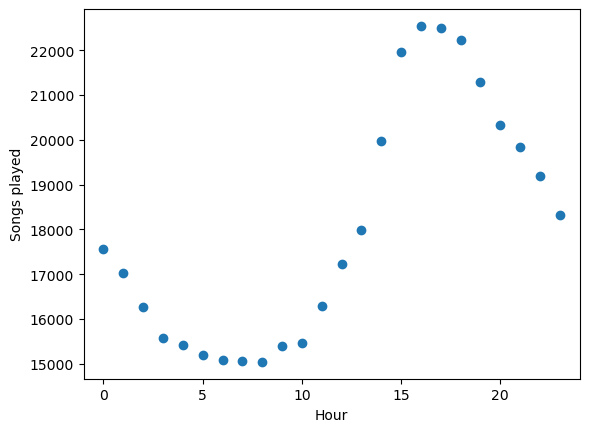

In [32]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
#plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [33]:
# the number of songs per day, including any repeat or partial listens, for the average user

# Ensure proper data types and create date column
event_data_cleaned = event_data_valid.withColumn("length", col("length").cast(DoubleType())) \
    .withColumn("userId", col("userId").cast(LongType())) \
    .withColumn("ts", col("ts").cast(LongType())) \
    .withColumn("date", from_unixtime(col("ts") / 1000).cast(DateType()))

# Calculate total songs and listening time per user per day
daily_user_stats = event_data_cleaned.groupBy("date", "userId") \
    .agg(
        count("*").alias("songs_played"),
        expr("sum(case when length is not null then length else 0 end) / 60").alias("daily_listening_time_minutes")
    )

# Calculate average songs played and listening time per day across all users
avg_daily_stats = daily_user_stats.groupBy("date") \
    .agg(
        avg("songs_played").alias("avg_songs_per_user"),
        avg("daily_listening_time_minutes").alias("avg_listening_time_minutes")
    )

# Calculate the overall averages
overall_avg = avg_daily_stats.select(
    avg("avg_songs_per_user").alias("overall_avg_songs_per_user"),
    avg("avg_listening_time_minutes").alias("overall_avg_listening_time_minutes")
)

# Round the results to 2 decimal places
avg_daily_stats = avg_daily_stats.select(
    "date",
    round("avg_songs_per_user", 2).alias("avg_songs_per_user"),
    round("avg_listening_time_minutes", 2).alias("avg_listening_time_minutes")
)

overall_avg = overall_avg.select(
    round("overall_avg_songs_per_user", 2).alias("overall_avg_songs_per_user"),
    round("overall_avg_listening_time_minutes", 2).alias("overall_avg_listening_time_minutes")
)

# Show results
print("Average daily stats per user:")
avg_daily_stats.orderBy("date").show(20)  # Showing more rows for a better overview

print("\nOverall average stats per user:")
overall_avg.show()

Average daily stats per user:
+----------+------------------+--------------------------+
|      date|avg_songs_per_user|avg_listening_time_minutes|
+----------+------------------+--------------------------+
|2018-10-01|             59.63|                    194.31|
|2018-10-02|             69.46|                    230.17|
|2018-10-03|             70.13|                     231.6|
|2018-10-04|              77.9|                    256.51|
|2018-10-05|             84.17|                    279.08|
|2018-10-06|             70.07|                    233.05|
|2018-10-07|             44.91|                    151.14|
|2018-10-08|             84.72|                     287.0|
|2018-10-09|             78.63|                    262.39|
|2018-10-10|             88.43|                    300.07|
|2018-10-11|             86.72|                     290.8|
|2018-10-12|             78.84|                     266.3|
|2018-10-13|             75.82|                    255.18|
|2018-10-14|             6

In [34]:
# Make graph
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = avg_daily_stats.orderBy("date").toPandas()
# Convert the 'date' column to datetime format
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

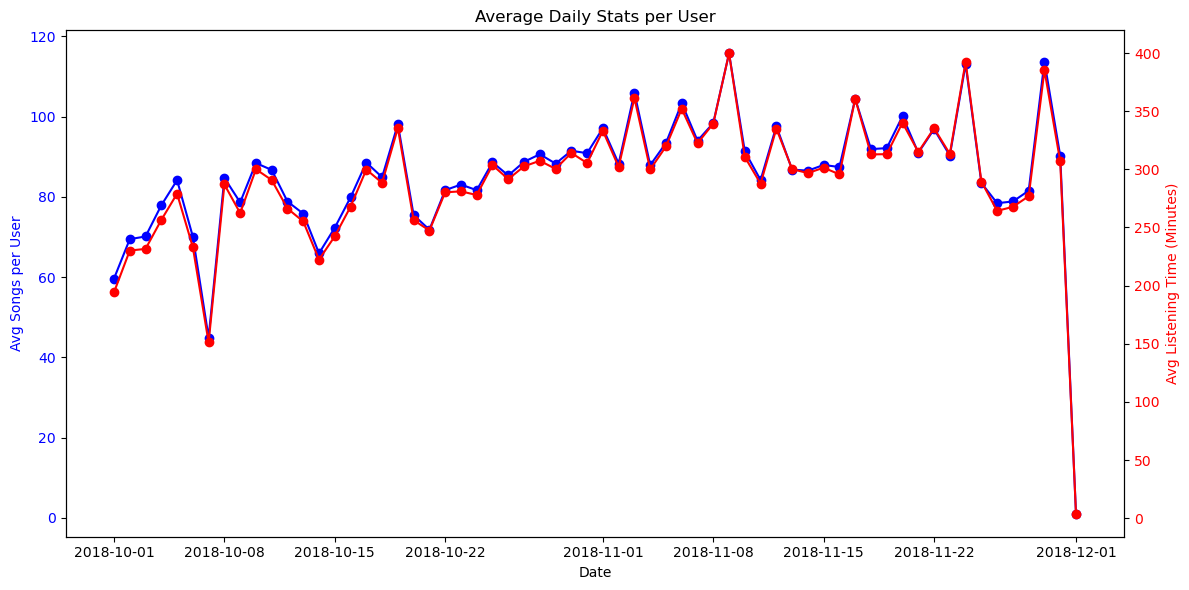

In [35]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot avg_songs_per_user on the first y-axis
ax1.plot(pandas_df['date'], pandas_df['avg_songs_per_user'], color='blue', marker='o', label='Avg Songs per User')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Songs per User', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot avg_listening_time_minutes
ax2 = ax1.twinx()
ax2.plot(pandas_df['date'], pandas_df['avg_listening_time_minutes'], color='red', marker='o', label='Avg Listening Time (Minutes)')
ax2.set_ylabel('Avg Listening Time (Minutes)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and rotate date labels for better readability
plt.title('Average Daily Stats per User')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In the plot we can see there was a upward trend both the average songs per user and average listening time. However, a sharp drop is detected in early December.

#### Core Metrics
Now let's focus on some core metrics for understanding the current state of the Sparkify business.

In [36]:
# Monthly active users. 
# The number of unique users who listened to 
# at least one song in the past month.
# Rather than looking at the total number of accounts,
# this number gives us a better sense of
# how many people are using the site on a regular basis.

# Get the maximum timestamp from the data to use as the current timestamp
max_timestamp = event_data_valid.agg(max("ts")).collect()[0][0]

# Calculate the timestamp for one month ago based on the maximum timestamp
one_month_ago = max_timestamp - (30 * 24 * 60 * 60 * 1000)

unique_users = event_data_valid.filter((col("page") == "NextSong") & (col("ts") >= one_month_ago)) \
    .select("userId") \
    .distinct() \
    .count()

print(f"Number of unique users who listened to at least one song in the past month: {unique_users}")

Number of unique users who listened to at least one song in the past month: 381


In [37]:
# Daily active users for each day in the past month.
# Both the total number and the percentage of the monthly active users.
# The daily actives help us understand how engaged our users are.
# Do they casually use Sparkify every now and
# then or does your service keep them coming back every day?

# Get the maximum timestamp from the data to use as the current timestamp
max_timestamp = event_data_valid.agg(max("ts")).collect()[0][0]

# Calculate the timestamp for one month ago based on the maximum timestamp
one_month_ago = max_timestamp - (30 * 24 * 60 * 60 * 1000)

# Filter the data for the last month and extract the date
daily_active_users = event_data_valid.filter(col("ts") >= one_month_ago) \
    .groupBy(to_date(from_unixtime(col("ts") / 1000)).alias("date")) \
    .agg(countDistinct("userId").alias("daily_active_users"))

# Calculate the total monthly active users
total_monthly_active_users = event_data_valid.filter(col("ts") >= one_month_ago) \
    .select("userId") \
    .distinct() \
    .count()

# Calculate the percentage of daily active users relative to monthly active users
daily_active_users = daily_active_users.withColumn("percentage_of_monthly_active_users", 
    (col("daily_active_users") / total_monthly_active_users) * 100)

daily_active_users.show()

+----------+------------------+----------------------------------+
|      date|daily_active_users|percentage_of_monthly_active_users|
+----------+------------------+----------------------------------+
|2018-11-02|               110|                28.720626631853786|
|2018-11-01|               106|                27.676240208877285|
|2018-11-17|                67|                  17.4934725848564|
|2018-11-26|                96|                 25.06527415143603|
|2018-11-24|                66|                17.232375979112273|
|2018-11-05|               125|                32.637075718015666|
|2018-12-01|                 4|                1.0443864229765014|
|2018-11-12|               101|                26.370757180156655|
|2018-11-08|               110|                28.720626631853786|
|2018-11-29|                89|                23.237597911227155|
|2018-11-16|               105|                27.415143603133156|
|2018-11-15|               114|                29.765013054830

In line with the plot of average listening time and songes per user, we can observe a sharp drop of active users from 96 in november 30th to 4 in December, 1st.

In [39]:
# Total number of paid and unpaid users
# This metric is tied directly to the monthly revenue that Sparkify earns.

# Count the total number of paid and unpaid users
user_counts = event_data_valid.groupBy("level") \
    .agg(countDistinct("userId").alias("total_users")) \
    .orderBy("level")

user_counts.show()

+-----+-----------+
|level|total_users|
+-----+-----------+
| free|        370|
| paid|        321|
+-----+-----------+



#### Cohort analysis
The main idea of cohort analysis is that someone who joins Sparkify a year ago probably behaves differently than a brand new user.
So, we should analyze them in separate groups called cohorts.
For each cohort, we can calculate two metrics: the percentage of users who upgrade to paid accounts within their first three months, and the percentage who cancel within three months. However, for this dataset we only have data of two months in 2018, so it is not possible to develop a cohort analysis.

#### Churn
Customer churn prediction identifies which customers are at a high risk of canceling their subscription or abandoning your product. Churn prediction allows us to tell whether a customer will leave and why. Source: https://userpilot.com/blog/churn-prediction/

In this analysis I will create a column Churn to use as the label for your model. I'll use the Cancellation Confirmation events to define churn, which happen for both paid and free users, as well as the Downgrade events.

In [40]:
# View Submit Downgrade events
event_data_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-----------------+------------------+----------------+-----------------------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|  registration_date|registration_year|registration_month|registration_day|days_since_registration|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-----------------+------------------+----------------+-----------------------+----+
|  null|Logged In|   Carter|     M|          117|    Cook|  null| paid|Chicago-Napervill...|   PUT|Submit 

In [41]:
# View Cancellation Confirmation events
event_data_valid.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-----------------+------------------+----------------+-----------------------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|  registration_date|registration_year|registration_month|registration_day|days_since_registration|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-----------------+------------------+----------------+-----------------------+----+
|  null|Cancelled|   Olivia|     F|           40|    Carr|  null| free|      Fort Wayne, IN|  

In [44]:
# Visualize cancelling user events
event_data_valid.select(["userId", "firstname", "page", "level", "song"]).where(event_data.userId == "17").collect()

[Row(userId='17', firstname='Kayla', page='Home', level='free', song=None),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song="Yesh Yesh Ya'll"),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Guyamas Sonora'),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Too Bad'),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Sehr kosmisch'),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Crying Lightning'),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Me And Bobby McGee'),
 Row(userId='17', firstname='Kayla', page='Thumbs Down', level='free', song=None),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Seat Belts'),
 Row(userId='17', firstname='Kayla', page='Thumbs Up', level='free', song=None),
 Row(userId='17', firstname='Kayla', page='NextSong', level='free', song='Hotdog'),
 Row(userId='17', firstname='Kayla', 

In [7]:
# Create flags for cancellation and downgrade events
event_data_valid = event_data_valid.withColumn(
    "cancellation_flag",
    when(col("page") == "Cancellation Confirmation", 1).otherwise(0)
)

event_data_valid = event_data_valid.withColumn(
    "downgrade_flag",
    when(col("page") == "Submit Downgrade", 1).otherwise(0)
)

In [8]:
# Aggregate by userId to determine if they have churned via cancellation or downgrade
user_churn = event_data_valid.groupBy("userId").agg(
    max("cancellation_flag").alias("cancellation"),
    max("downgrade_flag").alias("downgrade")
)

In [9]:
# Create a churn_type column
user_churn = user_churn.withColumn(
    "churn",
    when(col("cancellation") == 1, 2)
    .when(col("downgrade") == 1, 1)
    .otherwise(0)
)

# Show the resulting user churn DataFrame
user_churn.select("userId", "cancellation", "downgrade", "churn").show(10)

+------+------------+---------+-----+
|userId|cancellation|downgrade|churn|
+------+------------+---------+-----+
|100010|           1|        0|    2|
|200002|           1|        0|    2|
|   125|           0|        0|    0|
|   124|           1|        0|    2|
|     7|           0|        0|    0|
|200037|           1|        0|    2|
|   205|           0|        0|    0|
|   169|           0|        0|    0|
|   282|           0|        0|    0|
|   232|           0|        1|    1|
+------+------------+---------+-----+
only showing top 10 rows



In [10]:
# Join the churn type back to the original data
event_data_with_churn = event_data_valid.join(user_churn, on="userId", how="left")

In [11]:
event_data_with_churn.head() 

Row(userId='86', artist='Positive Force', auth='Logged In', firstName='Jaxon', gender='M', itemInSession=512, lastName='Reilly', length=383.242, level='paid', location='Jacksonville, FL', method='PUT', page='NextSong', registration=1531760527000, sessionId=3425, song='People Get On Up', status=200, ts=1541855892000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', cancellation_flag=0, downgrade_flag=0, cancellation=0, downgrade=0, churn=0)

In [50]:
# Count the total number of churned users
user_counts = event_data_with_churn.groupBy("churn") \
    .agg(countDistinct("userId").alias("total_users")) \
    .orderBy("churn")

user_counts.show()

+-----+-----------+
|churn|total_users|
+-----+-----------+
|    0|        273|
|    1|         76|
|    2|         99|
+-----+-----------+



In [51]:
event_data_with_churn.select("userId", "page", "churn").show(20)

+------+---------------+-----+
|userId|           page|churn|
+------+---------------+-----+
|    42|       NextSong|    1|
|    42|       NextSong|    1|
|   250|       NextSong|    1|
|   250|      Thumbs Up|    1|
|   250|       NextSong|    1|
|   104|       NextSong|    0|
|   104|       NextSong|    0|
|    40|       NextSong|    0|
|   283|       NextSong|    0|
|   283|       NextSong|    0|
|    92|       NextSong|    1|
|    92|       NextSong|    1|
|    92|      Thumbs Up|    1|
|    86|       NextSong|    0|
|    86|       NextSong|    0|
|    86|Add to Playlist|    0|
|   235|       NextSong|    1|
|   235|       NextSong|    1|
|    80|       NextSong|    0|
|    80|       NextSong|    0|
+------+---------------+-----+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

From the available data, to detect churn the variables that can be used are gender, location and registration. These variables need to be transformed to be used in the modelling phase.

#### Gender: Convert to Numeric Format

In [12]:
# The gender variable is categorical with values "M" (Male), "F" (Female) ans Null. We can convert these to numeric format using a mapping.

# Handle null values and map gender to numeric values
event_data_with_churn = event_data_with_churn.withColumn(
    "gender_numeric", 
    when(col("gender") == "M", 1)
    .when(col("gender") == "F", 0))

#### Location: One-Hot Encoding

In [13]:
# Index the location column
indexer = StringIndexer(inputCol="location", outputCol="location_indexed")
event_data_with_churn = indexer.fit(event_data_with_churn).transform(event_data_with_churn)

#### Registration: Time-Based Features

In [14]:
# Convert the registration timestamp to a date format
event_data_with_churn = event_data_with_churn.withColumn("registration_date", from_unixtime(col("registration")/1000))

# Extract year, month, and day
event_data_with_churn = event_data_with_churn.withColumn("registration_year", year(col("registration_date")))
event_data_with_churn = event_data_with_churn.withColumn("registration_month", month(col("registration_date")))
event_data_with_churn = event_data_with_churn.withColumn("registration_day", dayofmonth(col("registration_date")))

# Use the number of days since registration
event_data_with_churn = event_data_with_churn.withColumn("days_since_registration", datediff(current_date(), col("registration_date")))

In [15]:
# Show the resulting DataFrame with new features
event_data_with_churn.select("churn", "gender", "gender_numeric", "location", "location_indexed", "registration", "registration_year", "days_since_registration").show(5)

+-----+------+--------------+--------------------+----------------+-------------+-----------------+-----------------------+
|churn|gender|gender_numeric|            location|location_indexed| registration|registration_year|days_since_registration|
+-----+------+--------------+--------------------+----------------+-------------+-----------------+-----------------------+
|    2|     F|             0|Allentown-Bethleh...|            54.0|1536885688000|             2018|                   2181|
|    2|     F|             0|Allentown-Bethleh...|            54.0|1536885688000|             2018|                   2181|
|    2|     F|             0|Allentown-Bethleh...|            54.0|1536885688000|             2018|                   2181|
|    2|     F|             0|Allentown-Bethleh...|            54.0|1536885688000|             2018|                   2181|
|    2|     F|             0|Allentown-Bethleh...|            54.0|1536885688000|             2018|                   2181|
+-----+-

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [16]:
# As a first step break the data set into 80% of training data and 
# set aside 20%. Setting random seed to 42.
train_data, test_data = event_data_with_churn.randomSplit([0.8, 0.2], seed=42)

In [17]:
# Prepare the feature vector
feature_cols = ["gender_numeric", "location_indexed", "days_since_registration"]

# Assemble the features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

# Scale the features
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=False, withMean=False)    

#### Logistic Regression - Benchmark

In [59]:
# Create a logistic regression model for multi-class classification
lr = LogisticRegression(featuresCol="features", labelCol="churn")

In [60]:
# Define the pipeline with the stages
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Fit the pipeline model on the train data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predictions with the original churn type and predicted churn type
predictions.select("userId", "churn", "prediction").show(10)

+------+-----+----------+
|userId|churn|prediction|
+------+-----+----------+
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
+------+-----+----------+
only showing top 10 rows



In [61]:
# Evaluate the model using accuracy and f1-score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.5036247294449013
F1 Score: 0.3579053297460207


In [62]:
# Cross-validation for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_f1,
                    numFolds=3)

cvModel = cv.fit(train_data)

# Use the best model to make predictions
best_predictions = cvModel.transform(test_data)


metrics = ["f1", "accuracy"]

for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="churn", 
        predictionCol="prediction",
        metricName=metric
    )
    score = evaluator.evaluate(best_predictions)
    print(f"Best model {metric}: {score}")

#best_auc = evaluator.evaluate(best_predictions)
#print(f"Best AUC: {best_auc}")

# Print the best parameters
best_params = cvModel.bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")
    


Best model f1: 0.3595786162712549
Best model accuracy: 0.5078118354268863
Best Parameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: churn
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


#### Decision Trees

In [16]:
# Create a decision tree model for multi-class classification
dt = DecisionTreeClassifier(featuresCol="features", labelCol="churn")

In [17]:
# Define the pipeline with the stages
pipeline = Pipeline(stages=[assembler, scaler, dt])

# Fit the pipeline model on the train data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predictions with the original churn type and predicted churn type
predictions.select("userId", "churn", "prediction").show(10)

+------+-----+----------+
|userId|churn|prediction|
+------+-----+----------+
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
+------+-----+----------+
only showing top 10 rows



In [18]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.6102494305346831
F1 Score: 0.5435551367105234


In [19]:
# Cross-validation for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_f1,
                    numFolds=3)

cvModel = cv.fit(train_data)

# Use the best model to make predictions
best_predictions = cvModel.transform(test_data)


metrics = ["f1", "accuracy"]

for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="churn", 
        predictionCol="prediction",
        metricName=metric
    )
    score = evaluator.evaluate(best_predictions)
    print(f"Best model {metric}: {score}")

#best_auc = evaluator.evaluate(best_predictions)
#print(f"Best AUC: {best_auc}")

# Print the best parameters
best_params = cvModel.bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")
    


Best model f1: 0.9649956193027083
Best model accuracy: 0.9649058137446715
Best Parameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: churn
leafCol: 
maxBins: 64
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 956191873026065186


#### Random Forests

In [18]:
# Create a decision tree model for multi-class classification
rf = RandomForestClassifier(featuresCol="features", labelCol="churn")

In [19]:
# Define the pipeline with the stages
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Fit the pipeline model on the train data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predictions with the original churn type and predicted churn type
predictions.select("userId", "churn", "prediction").show(10)

+------+-----+----------+
|userId|churn|prediction|
+------+-----+----------+
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
|    10|    2|       0.0|
+------+-----+----------+
only showing top 10 rows



In [20]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.6359958790559636
F1 Score: 0.5798914861977191


In [21]:
# Cross-validation for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 15]) \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_f1,
                    numFolds=3)

cvModel = cv.fit(train_data)

# Use the best model to make predictions
best_predictions = cvModel.transform(test_data)


metrics = ["f1", "accuracy"]

for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="churn", 
        predictionCol="prediction",
        metricName=metric
    )
    score = evaluator.evaluate(best_predictions)
    print(f"Best model {metric}: {score}")

#best_auc = evaluator.evaluate(best_predictions)
#print(f"Best AUC: {best_auc}")

# Print the best parameters
best_params = cvModel.bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")
    

Best model f1: 0.9518212251917906
Best model accuracy: 0.9518057485278967
Best Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: churn
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -5387697053847413545
subsamplingRate: 1.0
